<a href="https://colab.research.google.com/github/Navaneeth1174/CREDIT-CARD-FRAUD-DETECTION/blob/main/CREDIT_CARD_FRAUD_DETECTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORTING LIBRARIES


In [1]:
import pandas as pd
import numpy as np
from itertools import combinations
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt  # Import matplotlib.pyplot for plotting
import seaborn as sns
import joblib
import os


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Data Preprocessing:**


In [3]:

from sklearn.preprocessing import StandardScaler


df = pd.read_csv('/content/drive/MyDrive/Summer Analytics/PROJECT/creditcard.csv')


# Checking for missing values
missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values)

scaler = StandardScaler()
df['Scaled_Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['Scaled_Time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))

df = df.drop(['Time', 'Amount'], axis=1)

pca_features = df.columns.difference(['Class', 'Scaled_Amount', 'Scaled_Time'])
df[pca_features] = scaler.fit_transform(df[pca_features])

print(df.head())


Missing values in each column:
 Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64
         V1        V2        V3        V4        V5        V6        V7  \
0 -0.694242 -0.044075  1.672773  0.973366 -0.245117  0.347068  0.193679   
1  0.608496  0.161176  0.109797  0.316523  0.043483 -0.061820 -0.063700   
2 -0.693500 -0.811578  1.169468  0.268231 -0.364572  1.351454  0.639776   
3 -0.493325 -0.112169  1.182516 -0.609727 -0.007469  0.936150  0.192071   
4 -0.591330  0.531541  1.021412  0.284655 -0.295015  0.071999  0.479302   

         V8        V9       V10  ...       V22       V23       V24       V25  \
0  0.082637  0.331128  0.083386  ...  0.382854 -0.17

**Exploratory Data Analysis (EDA):**

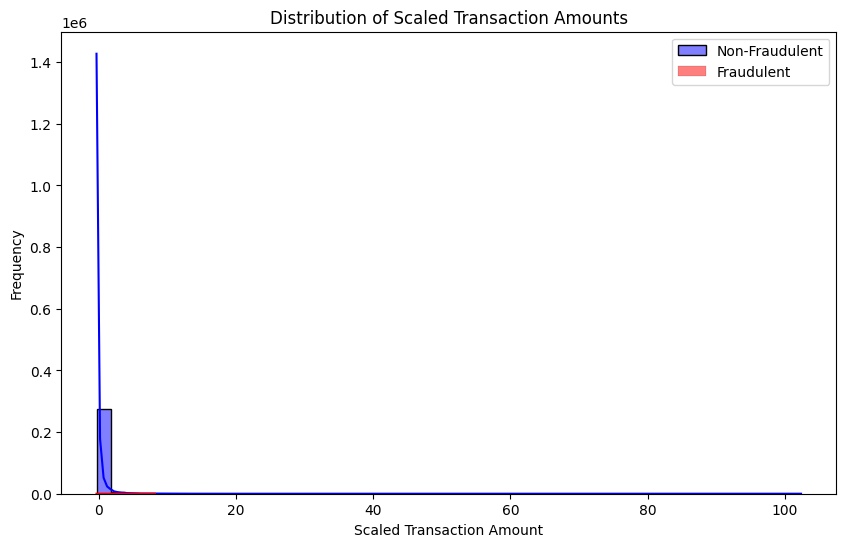

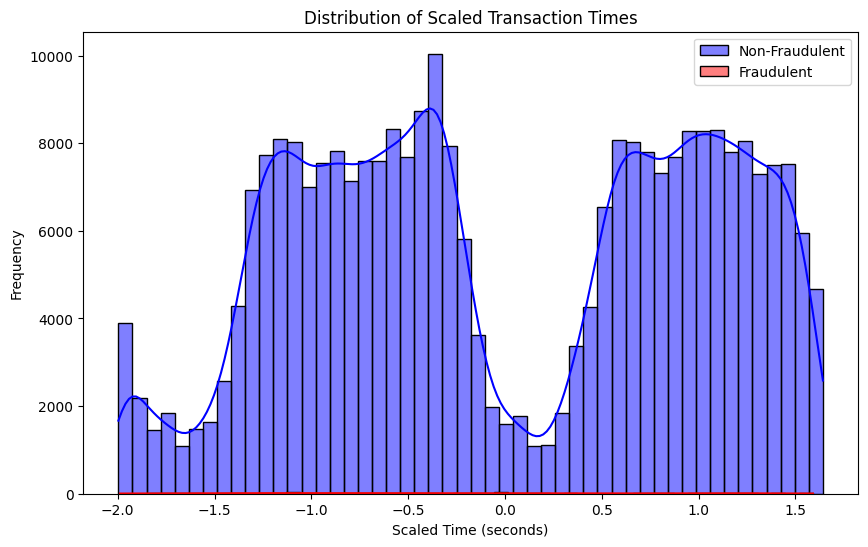

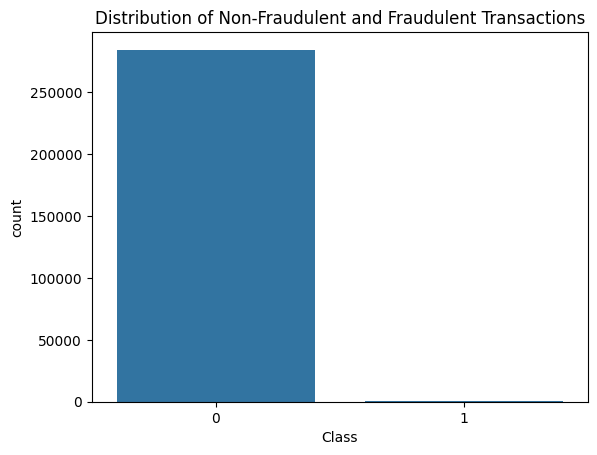

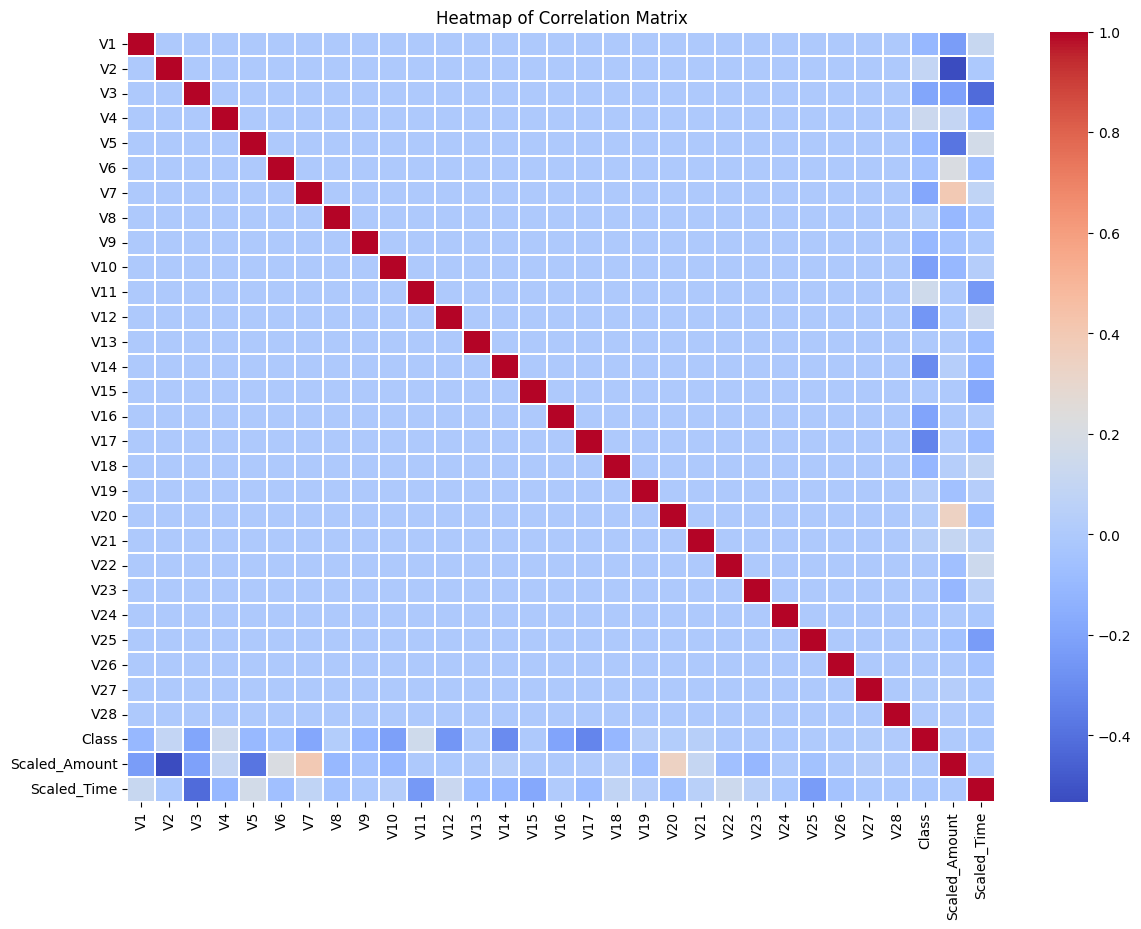

In [4]:

# Distribution of 'Scaled_Amount' for fraudulent and non-fraudulent transactions
plt.figure(figsize=(10, 6))
sns.histplot(df[df['Class'] == 0]['Scaled_Amount'], bins=50, color='blue', label='Non-Fraudulent', kde=True)
sns.histplot(df[df['Class'] == 1]['Scaled_Amount'], bins=50, color='red', label='Fraudulent', kde=True)
plt.title('Distribution of Scaled Transaction Amounts')
plt.xlabel('Scaled Transaction Amount')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Distribution of 'Scaled_Time' for fraudulent and non-fraudulent transactions
plt.figure(figsize=(10, 6))
sns.histplot(df[df['Class'] == 0]['Scaled_Time'], bins=50, color='blue', label='Non-Fraudulent', kde=True)
sns.histplot(df[df['Class'] == 1]['Scaled_Time'], bins=50, color='red', label='Fraudulent', kde=True)
plt.title('Distribution of Scaled Transaction Times')
plt.xlabel('Scaled Time (seconds)')
plt.ylabel('Frequency')
plt.legend()
plt.show()


sns.countplot(x='Class', data=df)
plt.title('Distribution of Non-Fraudulent and Fraudulent Transactions')
plt.show()


corr_matrix = df.corr()


plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.2)
plt.title('Heatmap of Correlation Matrix')
plt.show()


**Feature Engineering:**

In [5]:


df['Hour'] = df['Scaled_Time'] // 3600  # Converting scaled time to hours


bins = [-np.inf, 50, 100, 200, 500, np.inf]
labels = ['very low', 'low', 'medium', 'high', 'very high']
df['Amount_Category'] = pd.cut(df['Scaled_Amount'], bins=bins, labels=labels)


pca_features = df.columns.difference(['Class', 'Scaled_Amount', 'Scaled_Time', 'Hour', 'Amount_Category'])


interaction_data = []

for col1, col2 in combinations(pca_features, 2):
    interaction_col_name = f'{col1}_x_{col2}'
    interaction_data.append(df[col1] * df[col2])


interaction_df = pd.concat(interaction_data, axis=1)


df = pd.concat([df, interaction_df], axis=1)

print(df.head())



         V1        V2        V3        V4        V5        V6        V7  \
0 -0.694242 -0.044075  1.672773  0.973366 -0.245117  0.347068  0.193679   
1  0.608496  0.161176  0.109797  0.316523  0.043483 -0.061820 -0.063700   
2 -0.693500 -0.811578  1.169468  0.268231 -0.364572  1.351454  0.639776   
3 -0.493325 -0.112169  1.182516 -0.609727 -0.007469  0.936150  0.192071   
4 -0.591330  0.531541  1.021412  0.284655 -0.295015  0.071999  0.479302   

         V8        V9       V10  ...       368       369       370       371  \
0  0.082637  0.331128  0.083386  ... -0.085072 -0.047474 -0.020256 -0.081165   
1  0.071253 -0.232494 -0.153350  ... -0.002688 -0.002770  0.003098 -0.010110   
2  0.207373 -1.378675  0.190700  ... -0.492702 -0.233244 -0.075602  0.502626   
3  0.316018 -1.262503 -0.050468  ... -0.006992 -0.001435 -0.002360  0.009429   
4 -0.226510  0.744326  0.691625  ... -0.021241 -0.141402  0.066824 -0.219588   

        372       373       374       375       376       377  
0  0

**Model Development:**

In [6]:
from sklearn.model_selection import train_test_split

features = df.drop('Class', axis=1)
target = df['Class']

# Spliting data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


In [7]:
from sklearn.preprocessing import LabelEncoder


label_encoder = LabelEncoder()
X_train['Amount_Category_Encoded'] = label_encoder.fit_transform(X_train['Amount_Category'])
X_test['Amount_Category_Encoded'] = label_encoder.transform(X_test['Amount_Category'])

X_train = X_train.drop(['Amount_Category'], axis=1)
X_test = X_test.drop(['Amount_Category'], axis=1)


In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

lr_model = LogisticRegression(random_state=42, max_iter=1000)

lr_model.fit(X_train, y_train)

lr_predictions = lr_model.predict(X_test)
print("Logistic Regression Results:")
print("Accuracy:", accuracy_score(y_test, lr_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, lr_predictions))
print("Classification Report:\n", classification_report(y_test, lr_predictions))




/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Results:
Accuracy: 0.9991924440855307
Confusion Matrix:
 [[56844    20]
 [   26    72]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.78      0.73      0.76        98

    accuracy                           1.00     56962
   macro avg       0.89      0.87      0.88     56962
weighted avg       1.00      1.00      1.00     56962



In [9]:
from sklearn.ensemble import RandomForestClassifier

X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

rf_model = RandomForestClassifier(random_state=42)

rf_model.fit(X_train, y_train)

rf_predictions = rf_model.predict(X_test)

print("\nRandom Forest Results:")
print("Accuracy:", accuracy_score(y_test, rf_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, rf_predictions))
print("Classification Report:\n", classification_report(y_test, rf_predictions))


'from sklearn.ensemble import RandomForestClassifier\n\nX_train.columns = X_train.columns.astype(str)\nX_test.columns = X_test.columns.astype(str)\n\n# Instantiate Random Forest model\nrf_model = RandomForestClassifier(random_state=42)\n\n# Fit the model on training data\nrf_model.fit(X_train, y_train)\n\n# Predict on test data\nrf_predictions = rf_model.predict(X_test)\n\n# Evaluate the model\nprint("\nRandom Forest Results:")\nprint("Accuracy:", accuracy_score(y_test, rf_predictions))\nprint("Confusion Matrix:\n", confusion_matrix(y_test, rf_predictions))\nprint("Classification Report:\n", classification_report(y_test, rf_predictions))'

In [10]:
from sklearn.neural_network import MLPClassifier

X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

mlp_model = MLPClassifier(random_state=42, max_iter=500)

mlp_model.fit(X_train, y_train)

mlp_predictions = mlp_model.predict(X_test)

print("\nNeural Network (MLP) Results:")
print("Accuracy:", accuracy_score(y_test, mlp_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, mlp_predictions))
print("Classification Report:\n", classification_report(y_test, mlp_predictions))


'from sklearn.neural_network import MLPClassifier\n\nX_train.columns = X_train.columns.astype(str)\nX_test.columns = X_test.columns.astype(str)\n\n# Instantiate MLP Classifier model\nmlp_model = MLPClassifier(random_state=42, max_iter=500)\n\n# Fit the model on training data\nmlp_model.fit(X_train, y_train)\n\n# Predict on test data\nmlp_predictions = mlp_model.predict(X_test)\n\n# Evaluate the model\nprint("\nNeural Network (MLP) Results:")\nprint("Accuracy:", accuracy_score(y_test, mlp_predictions))\nprint("Confusion Matrix:\n", confusion_matrix(y_test, mlp_predictions))\nprint("Classification Report:\n", classification_report(y_test, mlp_predictions))'

In [11]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("After SMOTE:")
print(pd.Series(y_train_resampled).value_counts())


After SMOTE:
Class
0    227451
1    227451
Name: count, dtype: int64


**Model Evaluation:**

In [12]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='accuracy')

rf_grid_search.fit(X_train_resampled, y_train_resampled)

print("\nBest Parameters:", rf_grid_search.best_params_)
print("Best CV Score:", rf_grid_search.best_score_)

rf_best_model = rf_grid_search.best_estimator_
rf_best_predictions = rf_best_model.predict(X_test)

print("\nRandom Forest (Best Model) Results:")
print("Accuracy:", accuracy_score(y_test, rf_best_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, rf_best_predictions))
print("Classification Report:\n", classification_report(y_test, rf_best_predictions))


'from sklearn.model_selection import GridSearchCV\n\n# Define parameters for Grid Search\nparam_grid = {\n    \'n_estimators\': [50, 100, 200],\n    \'max_depth\': [None, 10, 20],\n    \'min_samples_split\': [2, 5, 10],\n    \'min_samples_leaf\': [1, 2, 4],\n    \'bootstrap\': [True, False]\n}\n\n# Instantiate Grid Search Cross-Validation\nrf_grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring=\'accuracy\')\n\n# Fit Grid Search on resampled training data\nrf_grid_search.fit(X_train_resampled, y_train_resampled)\n\n# Print best parameters and best score\nprint("\nBest Parameters:", rf_grid_search.best_params_)\nprint("Best CV Score:", rf_grid_search.best_score_)\n\n# Predict using the best model from Grid Search\nrf_best_model = rf_grid_search.best_estimator_\nrf_best_predictions = rf_best_model.predict(X_test)\n\n# Evaluate the best model\nprint("\nRandom Forest (Best Model) Results:")\nprint("Accuracy:", accuracy_score(y_test, rf_best_predictions))\npri

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

lr_grid_search = GridSearchCV(estimator=LogisticRegression(random_state=42, max_iter=1000),
                              param_grid=param_grid,
                              cv=3,
                              scoring='accuracy')

lr_grid_search.fit(X_train_resampled, y_train_resampled)

print("\nBest Parameters:", lr_grid_search.best_params_)
print("Best CV Score:", lr_grid_search.best_score_)

lr_best_model = lr_grid_search.best_estimator_
lr_best_predictions = lr_best_model.predict(X_test)

# Evaluating the best model
print("\nLogistic Regression (Best Model) Results:")
print("Accuracy:", accuracy_score(y_test, lr_best_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, lr_best_predictions))
print("Classification Report:\n", classification_report(y_test, lr_best_predictions))


**Deployment and Monitoring:**

In [ ]:

from sklearn.model_selection import cross_val_predict, cross_val_score, StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, precision_recall_curve, auc
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline


X = df.drop(['Class'], axis=1)
y = df['Class']

label_encoder = LabelEncoder()
X['Amount_Category_Encoded'] = label_encoder.fit_transform(X['Amount_Category'])


X = X.drop(['Amount_Category'], axis=1)


smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

mlp_model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_predictions = cross_val_predict(mlp_model, X_resampled, y_resampled, cv=cv, n_jobs=-1)

cv_precision = cross_val_score(mlp_model, X_resampled, y_resampled, cv=cv, scoring='precision', n_jobs=-1)
cv_recall = cross_val_score(mlp_model, X_resampled, y_resampled, cv=cv, scoring='recall', n_jobs=-1)
cv_f1 = cross_val_score(mlp_model, X_resampled, y_resampled, cv=cv, scoring='f1', n_jobs=-1)

precision, recall, _ = precision_recall_curve(y_resampled, cv_predictions)
auprc = auc(recall, precision)

print("Cross-Validation Metrics for MLP:")
print("Precision (mean): {:.4f}".format(cv_precision.mean()))
print("Recall (mean): {:.4f}".format(cv_recall.mean()))
print("F1-Score (mean): {:.4f}".format(cv_f1.mean()))
print("AUPRC: {:.4f}".format(auprc))

print("\nClassification Report for MLP:")
print(classification_report(y_resampled, cv_predictions))


In [ ]:
# Saving the trained model
joblib.dump(mlp_model, 'mlp_model.pkl')

# Saving the label encoder and scaler
joblib.dump(label_encoder, 'label_encoder.pkl')
joblib.dump(scaler, 'scaler.pkl')


In [ ]:

print(os.listdir())


In [ ]:
from google.colab import files

# Downloading the saved files
files.download('mlp_model.pkl')
files.download('label_encoder.pkl')
files.download('scaler.pkl')


**Success Metrics**

In [ ]:
from sklearn.metrics import precision_recall_curve, auc

lr_probs = lr_model.predict_proba(X_test)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, lr_probs)

auprc = auc(recall, precision)
print("AUPRC:", auprc)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_test, lr_predictions)
recall = recall_score(y_test, lr_predictions)

print("Precision:", precision)
print("Recall:", recall)


In [ ]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test, lr_predictions)
print("F1-Score:", f1)


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

roc_auc = roc_auc_score(y_test, lr_probs)
print("ROC-AUC:", roc_auc)

fpr, tpr, _ = roc_curve(y_test, lr_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid(True)
plt.show()
